In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import loompy as lp
import numpy as np
import pandas as pd
import scanpy as sc,anndata as ad
from pandas import Series,DataFrame
from scipy.sparse import hstack,vstack,csc_matrix
from scipy import sparse
import re
from matplotlib.backends.backend_pdf import PdfPages
#import leidenalg
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import rpy2.rinterface
import gseapy as gp
from rpy2.robjects import globalenv   
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from gseapy.plot import barplot, dotplot
pandas2ri.activate()
import scipy
from statannotations.Annotator import Annotator
import scipy.stats as stats
from sklearn import preprocessing


In [2]:
#确定读取路径，存储路径
main_path='D:\\CCLE'
save_data='D:\\CCLE\\data\\'
save_pic='D:\\CCLE\\pic\\'

In [124]:
#函数1：对Pvalue数值换成*，以方便显示
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

#函数2：针对特定基因绘制箱线图

def pic_gene(gene,pheno,tpm):  #传值三个：基因，分组表包含列Group，表达矩阵
    tmp_pic=pheno
    tmp_pic['gene']=tpm.loc[gene,tmp_pic.index]
    stat,p_value = scipy.stats.ttest_ind(tmp_pic.loc[tmp_pic['Group']=='Metastatic','gene'],
                                        tmp_pic.loc[tmp_pic['Group']!='Metastatic','gene'],
                                        equal_var=False)

    fig = plt.figure(figsize=(4, 5)) 
    colors=["#ff414d","#01c5c4"]
    sns.set_palette(sns.color_palette(colors))
    ax=sns.boxplot(x='Group',y='gene',data=tmp_pic,hue='Group')
    pairs=[("Metastatic", "Non_Metastatic")]
    annotator = Annotator(ax, pairs, data=tmp_pic, x='Group', y='gene')
    annotator.configure(test='Mann-Whitney', text_format='star',line_height=0.03,line_width=1)
    annotator.apply_and_annotate()

    plt.legend().set_visible(False)
    ax.set_xlabel("Group")
    ax.set_ylabel(gene)
    plt.savefig(save_pic+gene+'.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)

In [3]:
#file reading
#Gene expression
CCLE_TPM = pd.read_csv(main_path+'/raw/CCLE_expression.csv')
CCLE_TPM.index=CCLE_TPM['Unnamed: 0']
CCLE_TPM=CCLE_TPM.drop(columns='Unnamed: 0') 
CCLE_TPM.columns=[re.search(r"\S+",i).group() for i in CCLE_TPM.columns]
CCLE_TPM=CCLE_TPM.T
#data phenotype
CCLE_pheno = pd.read_csv(main_path+'/raw/sample_info.csv')
CCLE_pheno.index=CCLE_pheno['DepMap_ID']
#Mutation
CCLE_maf=pd.read_csv(main_path+'/raw/CCLE_mutations.csv') 
CCLE_maf['Tumor_Seq_Allele2']=CCLE_maf['Alternate_Allele']
CCLE_maf['Tumor_Sample_Barcode']=CCLE_maf['DepMap_ID']
#Metabolomics
CCLE_Metabolomics=pd.read_csv(main_path+'/raw/Metabolomics.csv') 
CCLE_Metabolomics.index=CCLE_Metabolomics['Unnamed: 0']
CCLE_Metabolomics=CCLE_Metabolomics.drop(columns='Unnamed: 0') 
#Protein expression
CCLE_pro = pd.read_csv(main_path+'/raw/Proteomics.csv')
CCLE_pro.index=CCLE_pro['Unnamed: 0']
CCLE_pro=CCLE_pro.drop(columns='Unnamed: 0') 
CCLE_pro.columns=[re.search(r"\S+",i).group() for i in CCLE_pro.columns]
CCLE_pro=CCLE_pro.T
#CRISPR data
CCLE_CRISPR=pd.read_csv(main_path+'/raw/CRISPR_(DepMap_22Q2_Public+Score,_Chronos).csv') 
CCLE_CRISPR.index=CCLE_CRISPR['Unnamed: 0']
CCLE_CRISPR=CCLE_CRISPR.drop(columns='Unnamed: 0') 
CCLE_CRISPR=CCLE_CRISPR.T
#Metmap
CCLE_metmap500MP=pd.read_csv(main_path+'/raw/MetMap_500__Metastatic_Potential.csv') 
CCLE_metmap500MP.index=CCLE_metmap500MP['Unnamed: 0']
CCLE_metmap500MP=CCLE_metmap500MP.drop(columns='Unnamed: 0') 
#drug sensitivity
CCLE_drug=pd.read_csv(main_path+'/raw/Drug_sensitivity_(PRISM_Repurposing_Primary_Screen)_19Q4.csv') 
CCLE_drug.index=CCLE_drug['Unnamed: 0']
CCLE_drug=CCLE_drug.drop(columns='Unnamed: 0') 
CCLE_drug.columns=[re.search(r"\S+",i).group() for i in CCLE_drug.columns]


C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\4041328432.py:12: DtypeWarning: Columns (3,19,22,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  CCLE_maf=pd.read_csv(main_path+'/raw/CCLE_mutations.csv')


In [343]:
#确定癌种：肺癌
CCLE_pheno_lung=CCLE_pheno.loc[(CCLE_pheno['primary_disease']=='Lung Cancer') ,:]
CCLE_metmap500MP_lung=CCLE_metmap500MP.loc[list(set(CCLE_pheno_lung.index).intersection(set(CCLE_metmap500MP.index))),:] #将有转移潜能细胞系和有表型的细胞系取交集
CCLE_metmap500MP_lung['CCLE_name']=list(CCLE_metmap500MP_lung.index)
CCLE_metmap500MP_lung['Celllinename']=list(CCLE_pheno.loc[CCLE_metmap500MP_lung.index,'cell_line_name'])

#按照Depmap官方划定 <-4 不转移 -4~-2 弱转移 -2转移 
for i in CCLE_metmap500MP_lung.columns[0:6]:
    CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung[i]< -4, i+'_color']='Non-metastatic'
    CCLE_metmap500MP_lung.loc[(CCLE_metmap500MP_lung[i]> -4) & (CCLE_metmap500MP_lung[i]< -2),i+'_color']='Weakly metastatic'
    CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung[i]> -2 ,i+'_color']='Metastatic'
CCLE_metmap500MP_lung = CCLE_metmap500MP_lung.sort_values(by=['all5'],ascending=False )

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\3517139581.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Barplot_all5_metapoten.pdf',dpi=400,facecolor='white',overwrite=True)


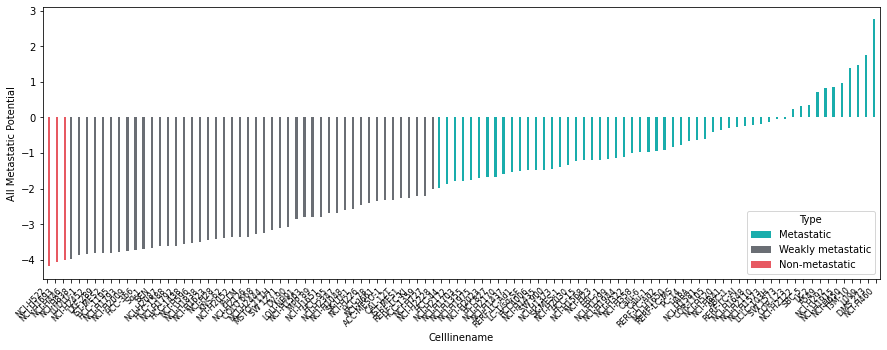

In [344]:
#绘制条形图:展示肺癌细胞系全部转移潜能
fig = plt.figure(figsize=(15, 5)) 
ax = fig.add_subplot(111)
bars =sns.barplot(x= 'Celllinename', y='all5',hue='all5_color',data=CCLE_metmap500MP_lung,order=CCLE_metmap500MP_lung.sort_values(by='all5')['Celllinename'] )
x_axis = bars.axes.get_xaxis()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45,fontsize=8)
ax.legend(title='Type')
plt.ylabel("All Metastatic Potential")
plt.savefig(save_pic+'Barplot_all5_metapoten.pdf',dpi=400,facecolor='white',overwrite=True)

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\1905678816.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Heatmap.5tissue.pdf',dpi=400,facecolor='white',overwrite=True)


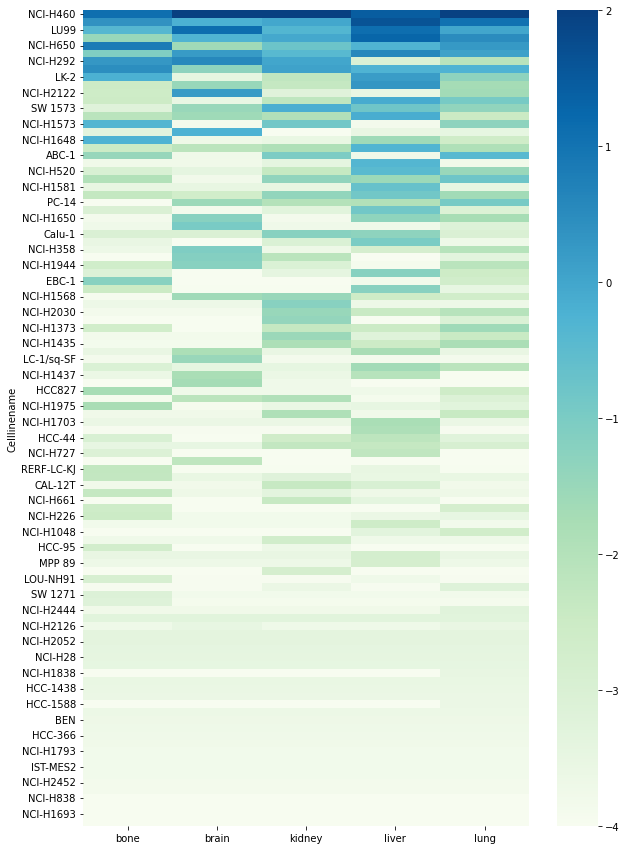

In [345]:
#热图:展示肺癌细胞系各个组织的转移潜能
tmp_pic=CCLE_metmap500MP_lung
tmp_pic.index=tmp_pic['Celllinename']
fig = plt.figure(figsize=(10, 15)) 
sns.heatmap(tmp_pic.loc[:,['bone','brain','kidney','liver','lung']] , vmin=-4, vmax=2 , cmap="GnBu")
plt.savefig(save_pic+'Heatmap.5tissue.pdf',dpi=400,facecolor='white',overwrite=True)

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\3659171242.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Heatmap.5tissue.cluster.pdf',dpi=400,facecolor='white',overwrite=True)


<Figure size 720x1080 with 0 Axes>

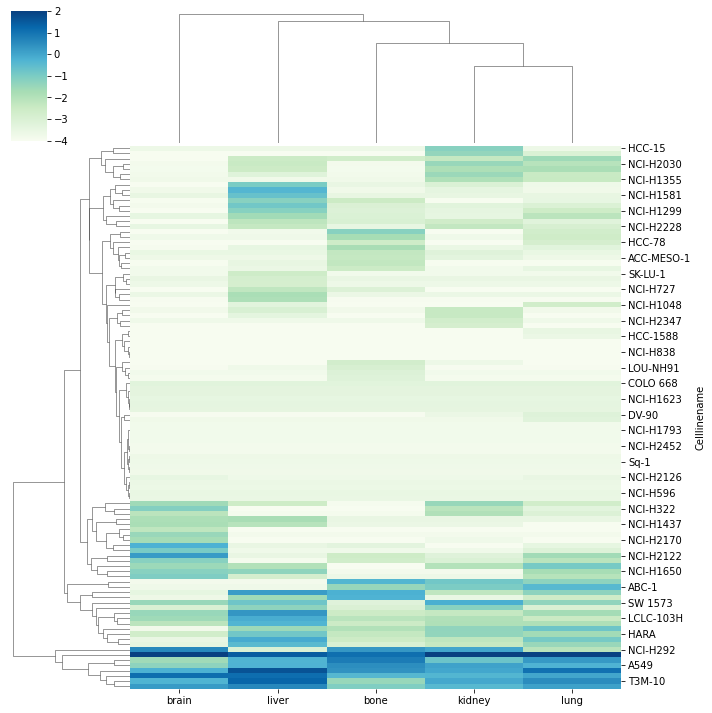

In [346]:
#聚类热图:展示肺癌细胞系各个组织的转移潜能：聚类后可见多种组织特异性转移细胞系
fig = plt.figure(figsize=(10, 15)) 
g = sns.clustermap(tmp_pic.loc[:,['bone','brain','kidney','liver','lung']] , vmin=-4, vmax=2 , cmap="GnBu")
plt.savefig(save_pic+'Heatmap.5tissue.cluster.pdf',dpi=400,facecolor='white',overwrite=True)

In [347]:
#定义样本：将>-2 细胞系定义为转移株 <-2 定义为不转移株
CCLE_metmap500MP_lung['Group']='Metastatic'
CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung['all5_color'] != 'Metastatic','Group']='Non_Metastatic'
CCLE_metmap500MP_lung.index=CCLE_metmap500MP_lung['CCLE_name']
intersect_sample=list( set(CCLE_metmap500MP_lung['CCLE_name']).intersection(set(CCLE_TPM.columns)) ) #与表达矩阵取交集
CCLE_metmap500MP_lung=CCLE_metmap500MP_lung.loc[intersect_sample,:]
CCLE_TPM_lung=CCLE_TPM.loc[:,intersect_sample]

#调用R语言limma包进行差异表达分析
design=pd.DataFrame({'Metastatic': [int(x) for x in list((CCLE_metmap500MP_lung['Group']=='Metastatic'))] ,"Non_Metastatic":[int(x) for x in list((CCLE_metmap500MP_lung['Group']=='Non_Metastatic'))]},index=list(CCLE_metmap500MP_lung['Group']))
limma=importr("limma")
rdf1=pandas2ri.py2rpy(CCLE_TPM_lung)
rdf2=pandas2ri.py2rpy(design)
globalenv['rdf1']=rdf1
globalenv['rdf2']=rdf2
rscript='''
contrasts_matrix<-makeContrasts("Metastatic-Non_Metastatic",levels=rdf2)
fit<-lmFit(rdf1,rdf2)
fit2<-contrasts.fit(fit,contrasts_matrix)
fit2<-eBayes(fit2)
temp<-topTable(fit2,coef=1,n=Inf)
nrDEG=na.omit(temp)
'''
Degs_lung=r(rscript)  #返回表达矩阵
Degs_lung['Group']='No.sig'
Degs_lung.loc[(Degs_lung['logFC']>0.58) & (Degs_lung['P.Value']<0.05),'Group']='Metastatic'  #logFC>0.58 P<0.05 的基因确定为转移株高表达基因
Degs_lung.loc[(Degs_lung['logFC']< -0.58) & (Degs_lung['P.Value']<0.05),'Group']='Non-Metastatic' #logFC<-0.58 P<0.05 的基因确定为非转移株高表达基因
Degs_lung['P.Val_log']=-np.log10(Degs_lung['P.Value']) 

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\2746733722.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Volcanoplot.pdf',dpi=400,facecolor='white',overwrite=True)


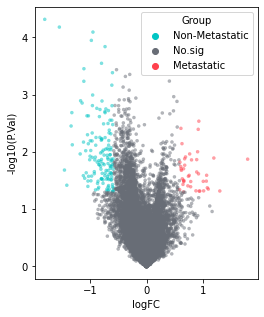

In [348]:
#绘制火山图
fig = plt.figure(figsize=(4, 5)) 
colors=["#01c5c4","#686d76","#ff414d"]
sns.set_palette(sns.color_palette(colors))
ax=sns.scatterplot(x='logFC',y='P.Val_log',data=Degs_lung,hue='Group',edgecolor=None,s=10,alpha=0.5)
ax.set_xlabel("logFC")
ax.set_ylabel("-log10(P.Val)")
plt.savefig(save_pic+'Volcanoplot.pdf',dpi=400,facecolor='white',overwrite=True)


d:\Users\liuxf\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\366482601.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Heatmap-DEGS.pdf',dpi=400,facecolor='white',overwrite=True)


<Figure size 288x1440 with 0 Axes>

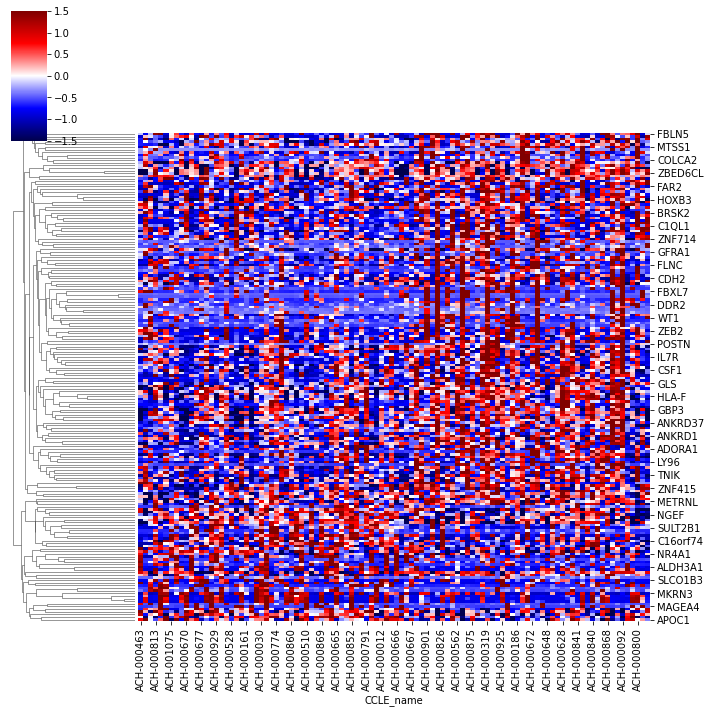

In [349]:
#绘制差异表达基因热图，效果不好（不用）
CCLE_metmap500MP_lung = CCLE_metmap500MP_lung.sort_values(by=['all5'],ascending=False )
sig_gene=list(Degs_lung.loc[Degs_lung['Group']!='No.sig',:].index)
fig = plt.figure(figsize=(4, 20)) 
sns.clustermap(CCLE_TPM_lung.loc[sig_gene,CCLE_metmap500MP_lung.index],cmap='seismic', z_score=0, vmin=-1.5, vmax=1.5,col_cluster=False)
plt.savefig(save_pic+'Heatmap-DEGS.pdf',dpi=400,facecolor='white',overwrite=True)

In [26]:
#利用gseapy包进行富集分析
gene_sets='KEGG_2016' #选择通路集
enr_up = gp.enrichr(gene_list=list(Degs_lung.loc[Degs_lung['Group']=='Metastatic',:].index),
                 gene_sets=gene_sets,organism='human',
                 outdir=save_pic+'/up',cutoff=0.5 )
enr_down = gp.enrichr(gene_list=list(Degs_lung.loc[Degs_lung['Group']=='Non-Metastatic',:].index),
                 gene_sets=gene_sets,organism='human',
                 outdir=save_pic+'/down',cutoff=0.5 )   
#基因GSEA分析
pre_res = gp.prerank(rnk=pd.DataFrame(Degs_lung['logFC'],index=Degs_lung.index).sort_values(by=['logFC'],ascending=False ), gene_sets='KEGG_2016',
                     processes=4,
                     outdir=save_pic+'/GSEA', format='pdf', seed=6)          

C:\Users\liuxf\AppData\Local\Temp\ipykernel_11496\3554000450.py:9: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=pd.DataFrame(Degs_lung['logFC'],index=Degs_lung.index).sort_values(by=['logFC'],ascending=False ), gene_sets='KEGG_2016',
2022-12-22 10:41:46,433 [WARNING] Duplicated values found in preranked stats: 0.79% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [29]:
#按照TF下游基因为基因集进行GSEA分析确定潜在TF
TF = pd.read_table(main_path+'/data/tf-target-infomation.txt')
TF_new={}
for i in np.unique(list(TF['TF'])):
     TF_new[i]=list(TF.loc[TF['TF']==i,'target'])
pre_TF = gp.prerank(rnk=pd.DataFrame(Degs_lung['logFC'],index=Degs_lung.index).sort_values(by=['logFC'],ascending=False ), gene_sets=TF_new,
                     processes=4,
                     outdir=save_pic+'/TF', format='pdf', seed=6) 
#基因ssGSEA分析得到全部通路打分                     
ssgsea =gp.ssgsea(data=CCLE_TPM_lung, gene_sets='KEGG_2016', outdir=save_pic+'/ssGSEA')                        

In [46]:
#确定富集到的TF
tf_lung=pd.read_csv(save_pic+'/TF/gseapy.gene_set.prerank.report.csv')
tf_lung=tf_lung.loc[tf_lung['NOM p-val']<0.05 , :]
tf_lung.index=list(tf_lung['Term'])
tf_lung=tf_lung.loc[[ i for i in tf_lung.index if i in CCLE_TPM_lung.index ] ,:]

In [96]:
#确定与NF-kappa B signaling pathway相关的TF
ssgsea_lung=pd.read_csv(save_pic+'/ssGSEA/gseapy.gene_set.ssgsea.report.csv')
ssgsea_lung=ssgsea_lung.pivot_table(index=['Name'],columns=['Term'],values=['ES'])
ssgsea_lung.columns=[pd.DataFrame(ssgsea_lung.columns).iloc[i,0][1] for i in range(0,len(ssgsea_lung.columns)) ]
sig_gsea=pd.read_csv(save_pic+'/GSEA/gseapy.gene_set.prerank.report.csv')
sig_gsea=sig_gsea.loc[sig_gsea['FDR q-val']<0.05 , :]
ssgsea_lung=ssgsea_lung.loc[:,sig_gsea['Term']]
tmp_gene=CCLE_TPM_lung.loc[list(tf_lung.index),list(ssgsea_lung.index)].T
tmp_gene=pd.concat([tmp_gene,ssgsea_lung], axis=1)
tmp_gene.corr(method='spearman').loc['NF-kappa B signaling pathway Homo sapiens hsa04064',:]


ETV6                                                                                0.452723
IRF2                                                                                0.271727
PRDM1                                                                               0.105719
KLF10                                                                               0.260725
CHD4                                                                               -0.184930
UBN1                                                                               -0.142385
CHD3                                                                               -0.115210
ERMAP                                                                              -0.060052
EPAS1                                                                               0.211596
RARA                                                                                0.240181
HES1                                                                  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\3429336342.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'IRF2_NF-kappa.pdf',dpi=400,facecolor='white',overwrite=True)


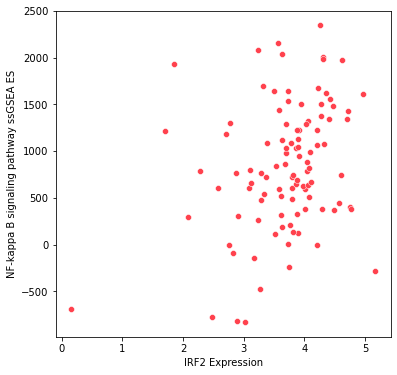

In [103]:
#绘制IRF2与NF-kappa B signaling pathway相关性点图
fig = plt.figure(figsize=(6, 6)) 
colors=["#ff414d","#01c5c4"]
sns.set_palette(sns.color_palette(colors))
ax=sns.scatterplot(x='IRF2',y='NF-kappa B signaling pathway Homo sapiens hsa04064',data=tmp_gene)

plt.legend().set_visible(False)
ax.set_xlabel("IRF2 Expression")
ax.set_ylabel('NF-kappa B signaling pathway ssGSEA ES')
plt.savefig(save_pic+'IRF2_NF-kappa.pdf',dpi=400,facecolor='white',overwrite=True)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metastatic vs. Non_Metastatic: Mann-Whitney-Wilcoxon test two-sided, P_val:2.037e-02 U_stat=9.465e+02


C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\2584324982.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+gene+'.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


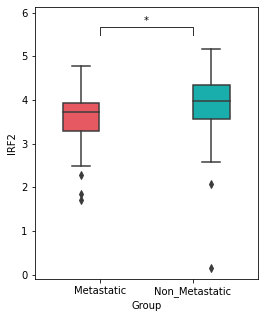

In [126]:
#绘制IRF2的boxplot
pic_gene('IRF2',CCLE_metmap500MP_lung,CCLE_TPM_lung)

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\3795894027.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'CRISPR.IRF2.pdf',dpi=400,facecolor='white',overwrite=True)


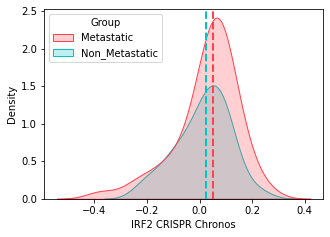

In [121]:
#确定IRF2对细胞系存活的影响程度
CCLE_CRISPR_lung=pd.DataFrame(CCLE_CRISPR.loc[gene,[ i for i in CCLE_metmap500MP_lung.index if i in CCLE_CRISPR.columns ] ] )
CCLE_CRISPR_lung['Group']=CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung.index,'Group']

fig = plt.figure(figsize=(5, 3.5)) 
colors=["#ff414d","#01c5c4"]
sns.set_palette(sns.color_palette(colors))
ax=sns.kdeplot(x='IRF2',data=CCLE_CRISPR_lung,hue='Group',fill=True)

median1 = np.median(CCLE_CRISPR_lung.loc[CCLE_CRISPR_lung['Group']=='Metastatic','IRF2'])
median2 = np.median(CCLE_CRISPR_lung.loc[CCLE_CRISPR_lung['Group']!='Metastatic','IRF2'])

# Add vertical lines at the medians
plt.axvline(median1, color='#ff414d', linestyle='dashed', linewidth=2)
plt.axvline(median2, color='#01c5c4', linestyle='dashed', linewidth=2)

ax.set_xlabel("IRF2 CRISPR Chronos")
ax.set_ylabel('Density')
plt.savefig(save_pic+'CRISPR.IRF2.pdf',dpi=400,facecolor='white',overwrite=True)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metastatic vs. Non_Metastatic: Mann-Whitney-Wilcoxon test two-sided, P_val:1.812e-02 U_stat=1.645e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03


C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\2584324982.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+gene+'.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)
C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\2584324982.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+gene+'.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


    ****: p <= 1.00e-04

Metastatic vs. Non_Metastatic: Mann-Whitney-Wilcoxon test two-sided, P_val:2.018e-02 U_stat=1.639e+03


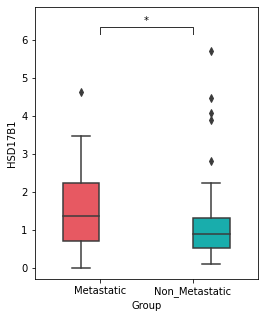

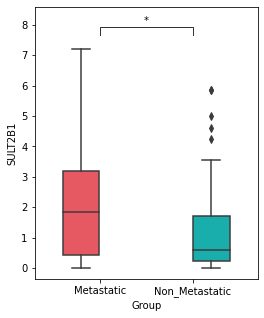

In [135]:
#绘制甲羟戊酸途径下游两个关键基因的boxplot
pic_gene('HSD17B1',CCLE_metmap500MP_lung,CCLE_TPM_lung)
pic_gene('SULT2B1',CCLE_metmap500MP_lung,CCLE_TPM_lung)

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\1201656043.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Metabolomics.Up.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


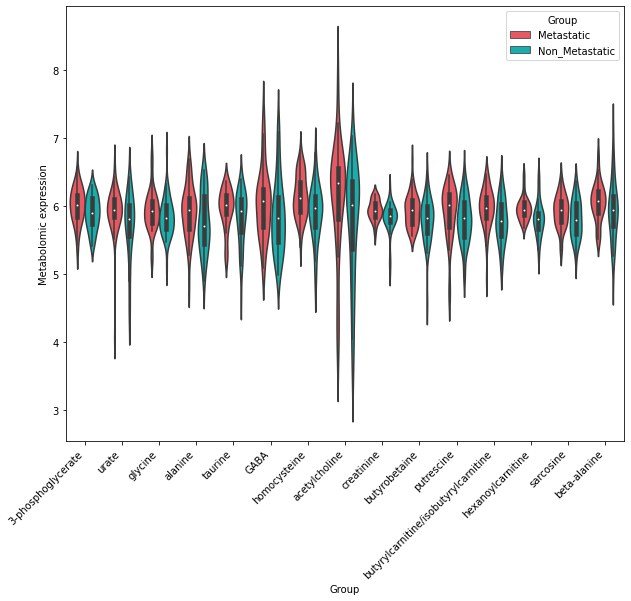

In [196]:

CCLE_Metabolomics_lung=CCLE_Metabolomics.loc[[ i for i in CCLE_metmap500MP_lung.index if i in CCLE_Metabolomics.index ] ,:] #确定代谢样本
CCLE_Metabolomics_lung['Group']=CCLE_metmap500MP_lung.loc[CCLE_Metabolomics_lung.index,'Group']

#确定转移组与非转移株之间的差异代谢物 在转移组调高的
pvalue=[]
for i in range(0,len(CCLE_Metabolomics_lung.columns)-1 ):
    pvalue.append(stats.mannwhitneyu(list(CCLE_Metabolomics_lung.loc[CCLE_Metabolomics_lung['Group']=='Metastatic',CCLE_Metabolomics_lung.columns[i]]) , list(CCLE_Metabolomics_lung.loc[CCLE_Metabolomics_lung['Group']!='Metastatic',CCLE_Metabolomics_lung.columns[i]]) ,alternative='greater'  )[1] )
pvalue=pd.DataFrame(pvalue,index=CCLE_Metabolomics_lung.columns[0:-1])
pvalue=pvalue.loc[pvalue[0]<0.05,:]
pvalue=pvalue.iloc[0:15,:]

CCLE_Metabolomics_lung=CCLE_Metabolomics_lung.loc[:,list(pvalue.index)]
CCLE_Metabolomics_lung['Group']=CCLE_metmap500MP_lung.loc[CCLE_Metabolomics_lung.index,'Group']
CCLE_Metabolomics_lung=CCLE_Metabolomics_lung.melt(id_vars='Group')

#绘制小提琴图
fig = plt.figure(figsize=(10, 8)) 
colors=["#ff414d","#01c5c4"]
sns.set_palette(sns.color_palette(colors))
ax=sns.violinplot(x='variable',y='value',data=CCLE_Metabolomics_lung,hue='Group')
x_axis = ax.axes.get_xaxis()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45,fontsize=10)
ax.set_xlabel("Group")
ax.set_ylabel('Metabolomic expression')
plt.savefig(save_pic+'Metabolomics.Up.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\1491184071.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Metabolomics.Down.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


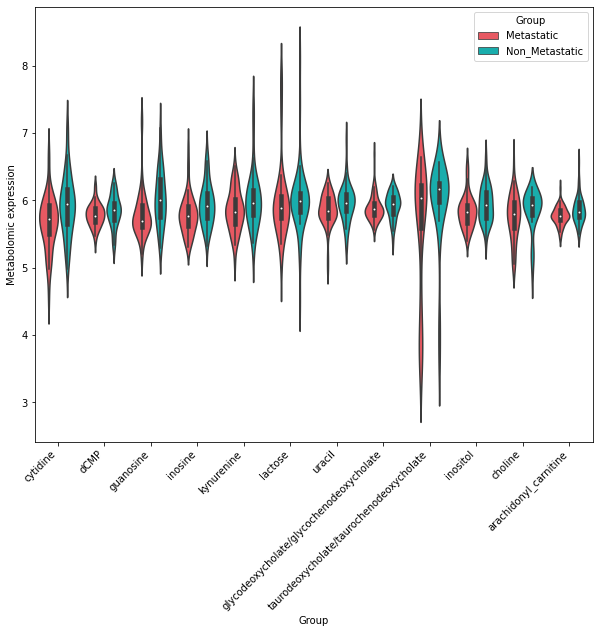

In [199]:
CCLE_Metabolomics_lung=CCLE_Metabolomics.loc[[ i for i in CCLE_metmap500MP_lung.index if i in CCLE_Metabolomics.index ] ,:]
CCLE_Metabolomics_lung['Group']=CCLE_metmap500MP_lung.loc[CCLE_Metabolomics_lung.index,'Group']

#确定转移组与非转移株之间的差异代谢物 在转移组调低的
pvalue=[]
for i in range(0,len(CCLE_Metabolomics_lung.columns)-1 ):
    pvalue.append(stats.mannwhitneyu(list(CCLE_Metabolomics_lung.loc[CCLE_Metabolomics_lung['Group']=='Metastatic',CCLE_Metabolomics_lung.columns[i]]) , list(CCLE_Metabolomics_lung.loc[CCLE_Metabolomics_lung['Group']!='Metastatic',CCLE_Metabolomics_lung.columns[i]]) ,alternative='less'  )[1] )
pvalue=pd.DataFrame(pvalue,index=CCLE_Metabolomics_lung.columns[0:-1])
pvalue=pvalue.loc[pvalue[0]<0.05,:]
pvalue=pvalue.iloc[0:12,:]

CCLE_Metabolomics_lung=CCLE_Metabolomics_lung.loc[:,list(pvalue.index)]
CCLE_Metabolomics_lung['Group']=CCLE_metmap500MP_lung.loc[CCLE_Metabolomics_lung.index,'Group']
CCLE_Metabolomics_lung=CCLE_Metabolomics_lung.melt(id_vars='Group')

fig = plt.figure(figsize=(10, 8)) 
colors=["#ff414d","#01c5c4"]
sns.set_palette(sns.color_palette(colors))
ax=sns.violinplot(x='variable',y='value',data=CCLE_Metabolomics_lung,hue='Group')
x_axis = ax.axes.get_xaxis()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45,fontsize=10)
ax.set_xlabel("Group")
ax.set_ylabel('Metabolomic expression')
plt.savefig(save_pic+'Metabolomics.Down.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


In [209]:
#确定转移组maf文件与非转移组maf文件
CCLE_maf_meta=CCLE_maf.loc[[i in list(CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung['Group']=='Metastatic',:].index) for i in CCLE_maf['Tumor_Sample_Barcode']] ,:]
CCLE_maf_nometa=CCLE_maf.loc[[i in list(CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung['Group']=='Non_Metastatic',:].index) for i in CCLE_maf['Tumor_Sample_Barcode']] ,:]
CCLE_maf_lung=pd.concat([CCLE_maf_meta, CCLE_maf_nometa])

In [217]:
#利用R语言maftools包处理maf文件
rdf1=pandas2ri.py2rpy(CCLE_maf_meta)
rdf2=pandas2ri.py2rpy(CCLE_maf_nometa)
globalenv['rdf1']=rdf1
globalenv['rdf2']=rdf2
rscript='''
cancer.maf.high <- read.maf(rdf1)
cancer.maf.low <- read.maf(rdf2)

pdf(paste0('Mutation-high-summary.pdf') , width =8, height =8)
plotmafSummary(maf=cancer.maf.high , rmOutlier=FALSE, addStat="median", dashboard=TRUE, titvRaw = FALSE);dev.off()

pdf(paste0('Mutation-low-summary.pdf') , width =8, height =8)
plotmafSummary(maf=cancer.maf.low , rmOutlier=FALSE, addStat="median", dashboard=TRUE, titvRaw = FALSE);dev.off()


pdf(paste0('Mutation-high-onco.pdf') , width =8, height =8)
oncoplot(maf=cancer.maf.high,top=10,fontSize = 0.6,showTumorSampleBarcodes = F);dev.off()

pdf(paste0('Mutation-low-onco.pdf') , width =8, height =8)
oncoplot(maf=cancer.maf.low,top=10,fontSize = 0.6,showTumorSampleBarcodes = F);dev.off()


pdf(paste0('Mutation-high vs low.pdf') , width =8, height =8)
comp <- mafCompare(m1=cancer.maf.high , m2=cancer.maf.low , m1Name="High Score", m2Name="Low Score", minMut=10)
forestPlot(mafCompareRes=comp, pVal=0.05, color=c("maroon", "royalblue"), geneFontSize=0.8);dev.off()

'''
r(rscript)

-Validating
--Non MAF specific values in Variant_Classification column:
  Stop_Codon_Ins
  Start_Codon_Del
-Silent variants: 10495 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  USH2A
-Processing clinical data
--Missing clinical data
-Finished in 1.300s elapsed (0.850s cpu) 
-Validating
--Non MAF specific values in Variant_Classification column:
  Stop_Codon_Ins
  Start_Codon_Del
-Silent variants: 8187 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  USH2A
-Processing clinical data
--Missing clinical data
-Finished in 0.870s elapsed (0.610s cpu) 


array([1], dtype=int32)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wt vs. Mut: Mann-Whitney-Wilcoxon test two-sided, P_val:4.268e-02 U_stat=4.375e+02


C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\3663311622.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'Mut'+mutation+'.'+gene+'.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)


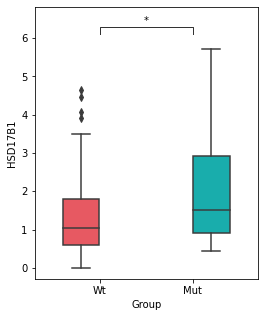

In [252]:
#确定ZFPM2突变组与非突变组HSD17B1的表达差异
gene='HSD17B1'
mutation='ZFPM2'
tmp_pic=CCLE_metmap500MP_lung
tmp_pic['gene']=CCLE_TPM_lung.loc[gene,tmp_pic.index]
tmp_pic['Group']='Wt'
tmp_pic.loc[list(np.unique(list(CCLE_maf_lung.loc[CCLE_maf_lung['Hugo_Symbol']==mutation,'Tumor_Sample_Barcode']))),'Group']='Mut'
stat,p_value = scipy.stats.ttest_ind(tmp_pic.loc[tmp_pic['Group']=='Wt','gene'],
                                        tmp_pic.loc[tmp_pic['Group']=='Mut','gene'],
                                        equal_var=False)
fig = plt.figure(figsize=(4, 5)) 
colors=["#ff414d","#01c5c4"]
sns.set_palette(sns.color_palette(colors))
ax=sns.boxplot(x='Group',y='gene',data=tmp_pic,hue='Group')
pairs=[("Wt", "Mut")]
annotator = Annotator(ax, pairs, data=tmp_pic, x='Group', y='gene')
annotator.configure(test='Mann-Whitney', text_format='star',line_height=0.03,line_width=1)
annotator.apply_and_annotate()

plt.legend().set_visible(False)
ax.set_xlabel("Group")
ax.set_ylabel(gene)
plt.savefig(save_pic+'Mut'+mutation+'.'+gene+'.boxplot.pdf',dpi=400,facecolor='white',overwrite=True)

In [295]:
#---转移组与非转移组药物敏感性比较------
CCLE_metmap500MP_lung['Group']='Metastatic'
CCLE_metmap500MP_lung.loc[CCLE_metmap500MP_lung['all5_color'] != 'Metastatic','Group']='Non_Metastatic'
intersect_sample=list( set(CCLE_metmap500MP_lung['CCLE_name']).intersection(set(CCLE_drug.index)) )
CCLE_metmap500MP_lung_drug=CCLE_metmap500MP_lung.loc[intersect_sample,:]
CCLE_drug_lung=CCLE_drug.loc[intersect_sample,:]
CCLE_drug_lung=CCLE_drug_lung.iloc[:, np.unique(CCLE_drug_lung.columns, return_index=True)[1]]
meta_bar=list(CCLE_metmap500MP_lung_drug.loc[CCLE_metmap500MP_lung_drug['Group']=='Metastatic',:].index)
nometa_bar=list(CCLE_metmap500MP_lung_drug.loc[CCLE_metmap500MP_lung_drug['Group']!='Metastatic',:].index)


In [335]:
pvalue=[]
for i in range(0,len(CCLE_drug_lung.columns) ):
    pvalue.append(stats.mannwhitneyu(list(CCLE_drug_lung.loc[meta_bar,CCLE_drug_lung.columns[i]].fillna(0)) , list(CCLE_drug_lung.loc[nometa_bar,CCLE_drug_lung.columns[i]].fillna(0)) )[1] ) #,alternative='greater'
pvalue=pd.DataFrame(pvalue,index=CCLE_drug_lung.columns)
pvalue=pvalue.loc[pvalue[0]<0.005,:]

C:\Users\liuxf\AppData\Local\Temp\ipykernel_33092\2412320771.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_pic+'drug_heatmap.pdf',dpi=400,facecolor='white',overwrite=True)


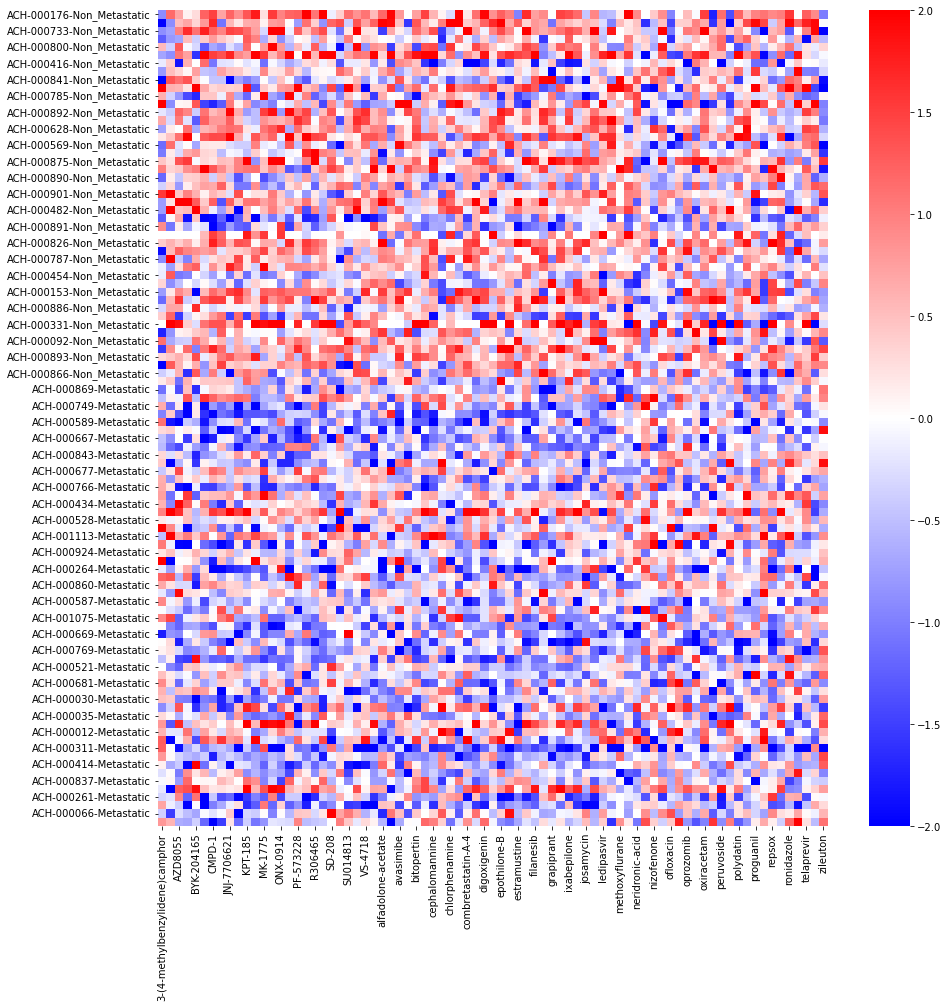

In [336]:
tmp_pic=CCLE_drug_lung.loc[:,pvalue.index]
tmp_pic['Group']=CCLE_metmap500MP_lung_drug.loc[tmp_pic.index,'Group']
tmp_pic=tmp_pic.sort_values(by=['Group'],ascending=False )

tmp_pic1=pd.DataFrame(preprocessing.scale(tmp_pic.iloc[:, :-1]))
tmp_pic1.index=tmp_pic.index
tmp_pic1.columns=tmp_pic.columns[0:-1]
tmp_pic1.index=tmp_pic1.index+'-'+tmp_pic['Group']
fig = plt.figure(figsize=(15, 15)) 
sns.heatmap(tmp_pic1 , vmin=-2, vmax=2 , cmap="bwr", center=0)
plt.savefig(save_pic+'drug_heatmap.pdf',dpi=400,facecolor='white',overwrite=True)